**Project Exam 2, Question 5**

Requirements: 

*   Apply autoencoder on Cifar_10 dataset
*   Pass result to CNN or LSTM or 3-Layers model for classification
*   Repeat after applying PCA on the dataset
*   Compare results of non-PCA and PCA approach



**AUTOENCODER + CNN**

#### Import Libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import load_model

import numpy as np
import matplotlib.pyplot as plt
from time import time
from random import randint

from keras.datasets import cifar10

from keras.utils import np_utils
from keras.constraints import maxnorm
from keras.layers import Dense, Input
from keras.layers import Dropout
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.models import Model
from keras.callbacks import TensorBoard

from keras import regularizers
from keras import backend as K

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

K.set_image_data_format('channels_first')
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#####Make sure the code runs on TF GPU

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num TPUs Available: ", len(tf.config.experimental.list_physical_devices('TPU')))

Num GPUs Available:  1
Num TPUs Available:  0


####Apply autoencoder to the Cifar_10 dataset

In [ ]:
j = randint(0,10000)

##### Single fully-connected neural layer as encoder and decoder

In [ ]:
# this is the size of our encoded representations
encoding_dim = 128  # 128 floats -> compression of factor 24, assuming the input is 3072 floats

In [ ]:
# this is our input placeholder
input_img = Input(shape=(3072,))

In [ ]:
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)

In [ ]:
#hidden_1 = Dense(128, activation='relu')(encoded)

In [ ]:
# "decoded" is the loss reconstruction of the input
decoded = Dense(3072, activation='sigmoid')(encoded)

In [ ]:
# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

##### Seperate encoder model

In [ ]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

##### Decoder model

In [ ]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))

In [ ]:
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]

In [ ]:
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

##### Autoencoder model configuration

In [ ]:
# this model maps an input to its encoded representation
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

##### Prepare input data

In [ ]:
# load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [ ]:
# perform a transpose reshape from (3,32,32) to (32,32,3)
x_train = x_train.reshape(50000,3,32,32).transpose(0,2,3,1).astype("uint8")
x_test = x_test.reshape(10000,3,32,32).transpose(0,2,3,1).astype("uint8")


##### Normalize all values between 0 and 1, and flatten 32x32 images into vectors of size 3072

In [ ]:
# normalize inputs from 0-255 to 0.0-1.0
x_train = x_train.astype('uint8') / 255.
x_test = x_test.astype('uint8') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [ ]:
# print shape of data
print(x_train.shape)
print(x_test.shape)

(50000, 3072)
(10000, 3072)


##### Include Y data

In [ ]:
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

In [ ]:
print(num_classes)

10


##### Train autoencoder

In [ ]:
# autoencoder training and tensorboard logging
tensorboard = TensorBoard(log_dir='2', histogram_freq=0, write_graph=True, write_images=False)
history = autoencoder.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True, validation_data=(x_test, x_test), callbacks=[tensorboard])

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 66us/step - loss: 0.6926 - accuracy: 0.0066 - val_loss: 0.6913 - val_accuracy: 0.0072
Epoch 2/50
50000/50000 [==============================] - 3s 62us/step - loss: 0.6873 - accuracy: 0.0081 - val_loss: 0.6815 - val_accuracy: 0.0090
Epoch 3/50
50000/50000 [==============================] - 3s 62us/step - loss: 0.6759 - accuracy: 0.0093 - val_loss: 0.6705 - val_accuracy: 0.0098
Epoch 4/50
50000/50000 [==============================] - 3s 61us/step - loss: 0.6657 - accuracy: 0.0101 - val_loss: 0.6608 - val_accuracy: 0.0105
Epoch 5/50
50000/50000 [==============================] - 3s 61us/step - loss: 0.6572 - accuracy: 0.0108 - val_loss: 0.6539 - val_accuracy: 0.0110
Epoch 6/50
50000/50000 [==============================] - 3s 63us/step - loss: 0.6518 - accuracy: 0.0111 - val_loss: 0.6498 - val_accuracy: 0.0112
Epoch 7/50
50000/50000 [==============================] - 3s 62us/st

##### Visualize reconstructed inputs and encoded representations

In [ ]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

###### Preparing autoecoder output for CNN

In [ ]:
x_train2 = x_train

for i in range(0, 50000):
  prediction = autoencoder.predict(x_train[i].reshape(1,3072))
  x_train2[i] = prediction

In [ ]:
x_test2 = x_test.copy()

for i in range(0, 10000):
  prediction = autoencoder.predict(x_test[i].reshape(1,3072))
  x_test2[i] = prediction

Change input shape from (,3072) to (,32,32,3)

In [ ]:
x_train2 = np.array(x_train2).reshape([-1, 32, 32, 3]) 
x_train2.shape

(50000, 32, 32, 3)

In [ ]:
x_test2 = np.array(x_test2).reshape([-1, 32, 32, 3]) 
x_test2.shape

(10000, 32, 32, 3)

###### Showcase result of autoencoder on a random image from test dataset

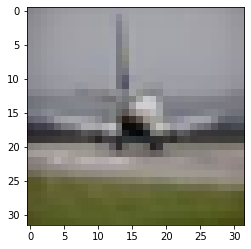

In [ ]:
# display original
plt.imshow(x_test[j].reshape(32,32,3))
plt.show()

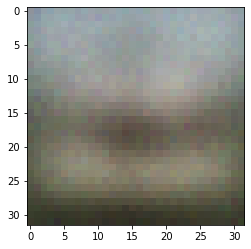

In [ ]:
# display reconstruction
plt.imshow(x_test2[j].reshape(32,32,3))
plt.show()

##### Model accuracy and model loss plots 

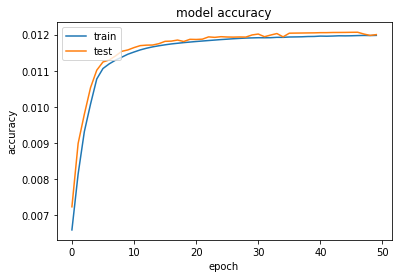

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

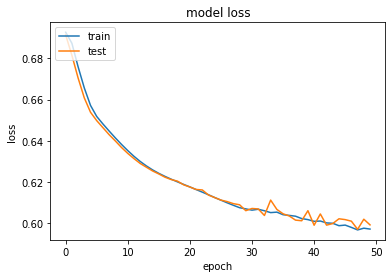

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

####CNN Model

2D convolutinal model

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32,32,3), kernel_constraint=maxnorm(3)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_constraint=maxnorm(3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 3)         9248      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 3)         9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 16, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)              

In [ ]:
# Compile model
epochs = 50
lrate = 0.01
decay = lrate/epochs
sgd = keras.optimizers.SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [ ]:
# Fit the model
historynew = model.fit(x_train2, y_train, validation_data=(x_test2, y_test), epochs=epochs, batch_size=32)

Epoch 1/50
1563/1563 [==============================] - 11s 7ms/step - loss: 1.9336 - accuracy: 0.2915 - val_loss: 1.8028 - val_accuracy: 0.3613
Epoch 2/50
1563/1563 [==============================] - 10s 7ms/step - loss: 1.7829 - accuracy: 0.3559 - val_loss: 1.7402 - val_accuracy: 0.3756
Epoch 3/50
1563/1563 [==============================] - 10s 7ms/step - loss: 1.7288 - accuracy: 0.3768 - val_loss: 1.7079 - val_accuracy: 0.3968
Epoch 4/50
1563/1563 [==============================] - 11s 7ms/step - loss: 1.6929 - accuracy: 0.3914 - val_loss: 1.6628 - val_accuracy: 0.4070
Epoch 5/50
1563/1563 [==============================] - 11s 7ms/step - loss: 1.6660 - accuracy: 0.4019 - val_loss: 1.6236 - val_accuracy: 0.4288
Epoch 6/50
1563/1563 [==============================] - 11s 7ms/step - loss: 1.6437 - accuracy: 0.4089 - val_loss: 1.5994 - val_accuracy: 0.4304
Epoch 7/50
1563/1563 [==============================] - 11s 7ms/step - loss: 1.6286 - accuracy: 0.4153 - val_loss: 1.5985 - val_ac

In [ ]:
# Final evaluation of the model
scores = model.evaluate(x_test2, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 48.14%


#### Accuracy and loss plot

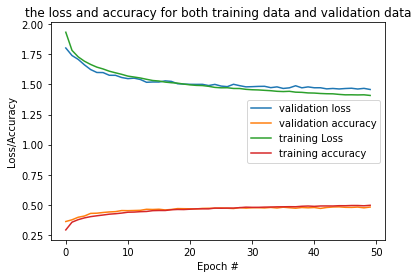

In [ ]:
plt.figure()
plt.plot(np.arange(0, 50), historynew.history["val_loss"], label="validation loss")
plt.plot(np.arange(0, 50), historynew.history["val_accuracy"], label="validation accuracy")
plt.plot(np.arange(0, 50), historynew.history["loss"], label="training Loss")
plt.plot(np.arange(0, 50), historynew.history["accuracy"], label="training accuracy")
plt.title("the loss and accuracy for both training data and validation data")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="best")

#### Predict and confirm model performance

In [ ]:
model.save('./savedModel' + '.h5')

In [ ]:
model2 = tf.keras.models.load_model('savedModel.h5')

In [ ]:
class_name = [
  'airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
imgarr = [None] * 10

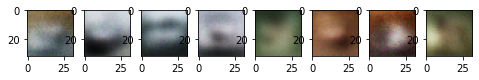

In [ ]:
# plotting 8 reconstructed images that will be predicted
fig = plt.figure(figsize=(8,8))

for i in range(8):
  ax = fig.add_subplot(8, 8, i+1)
  ax.imshow(x_test2[i], cmap = plt.cm.bone)

plt.show()

In [ ]:
# predicted labels from CNN for images above
for img in range(0,8):
  predict_class = model2.predict_classes(x_test2[[img],:])
  print("predicted for image[" + str(img+1) +"]: " + str(predict_class[0]) + ' ' + str(class_name[predict_class[0]]))

predicted for image[1]: 1 automobile
predicted for image[2]: 8 ship
predicted for image[3]: 8 ship
predicted for image[4]: 8 ship
predicted for image[5]: 4 deer
predicted for image[6]: 6 frog
predicted for image[7]: 3 cat
predicted for image[8]: 6 frog


cat
ship
ship
airplane
frog
frog
automobile
frog


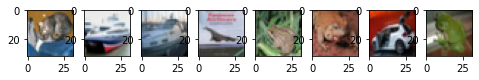

In [ ]:
# plotting original images from above
fig = plt.figure(figsize=(8,8))

for i in range(8):
  ax = fig.add_subplot(8, 8, i+1)
  ax.imshow(x_test[i].reshape(32,32,3), cmap = plt.cm.bone)

  imgarr = y_test[i]
  for j in range(0,len(imgarr)):
    if imgarr[j]== 1:
      print(class_name[j])
      break

plt.show()
